Comparisons of locomotion predictions of different mechanistic latent variable models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from disp import set_plot


STRAIN_KEY = '_'.join(['NM91', 'ZH23']).lower()
REG_KEY = 'ridge_alpha_10'

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

# Basic comparison of single vs population fits using different neural models.

In [2]:
NRL_MDLS = [
#     'lin',  # linear neural model
    'lin2e',  # linear neural model (two-exp fit)
#     'linr',  # linear neural model (fit w ridge regr)
#     'ln',  # linear-nonlinear model
    'ln2e',  # linear-nonlinear model (two-exp fit)
#     'lnr',  # linear-nonlinear model (fit w ridge regr)
    'ma',  # mult-adapt neural model
#     'masoff',  # mult-adapt neural model with sine offset responses
]

LABELS = {
    'lin2e': 'Linear',
    'ln2e': 'LN',
    'ma': 'MA',
    'MTN': 'Motion',
}

In [3]:
# heuristic predictors
time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]

# linear fits
lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]

# single-neuorn fits
single_rslts = [
    np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]
    for nrl_mdl in NRL_MDLS
]

# ppln fits
ppln_rslts = [
    np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
    for nrl_mdl in NRL_MDLS
]

# shuffled MA fit
shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]

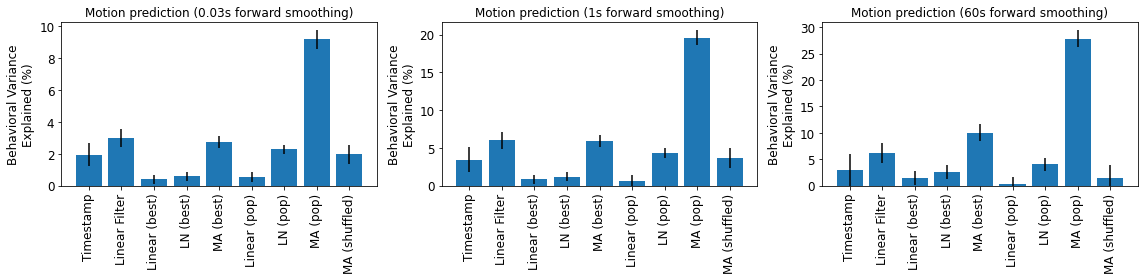

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), tight_layout=True)
                
for ax, twdw in zip(axs, TWDWS):
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    # heuristics
    labels.append('Timestamp')
    r2_mns.append(time_rslt['r2_test'][targ].mean())
    r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))
    
    # linear fits
    labels.append('Linear Filter')
    r2_mns.append(lin_rslt['r2_test'][targ].mean())
    r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))
    
    # single neuron results
    for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
        r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
        labels.append(f'{LABELS[nrl_mdl]} (best)')
        r2_mns.append(r2_maxs.mean())
        r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))
        
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{LABELS[nrl_mdl]} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
    # shuffled MA fit
    labels.append('MA (shuffled)')
    r2_mns.append(shfl_rslt['r2_test'][targ].mean())
    r2_sems.append(shfl_rslt['r2_test'][targ].std() / np.sqrt(shfl_rslt['nshfl']))
        
    r2_mns = np.array(r2_mns)
    r2_sems = np.array(r2_sems)
    
    ax.bar(np.arange(len(r2_mns)), 100*r2_mns, yerr=100*r2_sems)
    ax.set_ylim(bottom=0)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    set_plot(ax, y_label='Behavioral Variance\nExplained (%)', title=f'{LABELS[TARG_BHV]} prediction ({twdw}s forward smoothing)', font_size=12)
    
fig.savefig('ms/fig2ad.svg')

# Behavioral predictions from perturbed surrogate population recordings

In [5]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full MA pop.'),
    (None, None, None),
    ('ma_no_sel', 'ma_alt', 'No selectivity'),
    ('ma_pure_sel', 'ma_alt', 'Pure selectivity'),
    ('ma_sine_sel', 'ma_alt', 'Sine selective'),
    ('ma_pulse_sel', 'ma_alt', 'Pulse selective'),
    (None, None, None),
    ('ma_stim_inv_adapt', 'ma_alt', 'Stim-inv adapt'),
    ('ma_no_adapt', 'ma_alt', 'No adaptation'),
    (None, None, None),
    ('ma_fast_r_fast_a', 'ma_alt', r'Fast $\tau_r$, fast $\tau_a$'),
    ('ma_fast_r_med_a', 'ma_alt', r'Fast $\tau_r$, med $\tau_a$'),
    ('ma_fast_r_slow_a', 'ma_alt', r'Fast $\tau_r$, slow $\tau_a$'),
    (None, None, None),
    ('ma_med_r_fast_a', 'ma_alt', r'Med. $\tau_r$, fast $\tau_a$'),
    ('ma_med_r_med_a', 'ma_alt', r'Med. $\tau_r$, med $\tau_a$'),
    ('ma_med_r_slow_a', 'ma_alt', r'Med. $\tau_r$, slow $\tau_a$'),
    (None, None, None),
    ('ma_slow_r_fast_a', 'ma_alt', r'Slow $\tau_r$, fast $\tau_a$'),
    ('ma_slow_r_med_a', 'ma_alt', r'Slow $\tau_r$, med $\tau_a$'),
    ('ma_slow_r_slow_a', 'ma_alt', r'Slow $\tau_r$, slow $\tau_a$'),
]

rslts_1 = []
rslts_60 = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder is not None:
        fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_mtn_ridge_alpha_10.npy', allow_pickle=True)[0]

        nsplit = len(fit_data['r2_test']['MTN_MN_60'])

        r2_1 = fit_data['r2_test']['MTN_MN_1'].mean()
        err_1 = fit_data['r2_test']['MTN_MN_1'].std()/np.sqrt(nsplit)
        
        r2_60 = fit_data['r2_test']['MTN_MN_60'].mean()
        err_60 = fit_data['r2_test']['MTN_MN_60'].std()/np.sqrt(nsplit)
    else:
        r2_1 = np.nan
        err_1 = np.nan
        r2_60 = np.nan
        err_60 = np.nan
    
    rslts_1.append((key, r2_1, err_1))
    rslts_60.append((key, r2_60, err_60))

/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


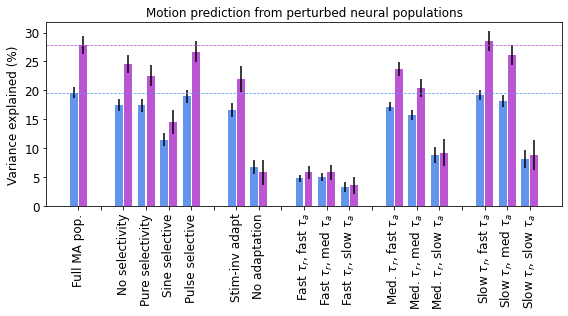

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5), tight_layout=True, sharey=True)
colors = ['cornflowerblue', 'mediumorchid']
for crslts, (color, rslts) in enumerate(zip(colors, [rslts_1, rslts_60])):
    x_offset = -.2 + crslts*.4
    for crslt, (key, r2, err) in enumerate(rslts):
        ax.bar([crslt+x_offset], [r2*100], yerr=[err*100], width=.35, color=color)

    ax.axhline(100*rslts[0][1], ls='--', lw=.75, color=color)
    ax.set_xticks(np.arange(len(rslts)))
    ax.set_xticklabels([rslt[0] for rslt in rslts], rotation=90)

    set_plot(ax, y_label='Variance explained (%)', title='Motion prediction from perturbed neural populations', font_size=12)
    
fig.savefig('ms/fig2j.svg')

## MTN prediction from heuristics

In [7]:
SONG_HEURS = ['N_S_ONSETS', 'N_P_ONSETS', 'N_B_ONSETS', 'S_TOTAL', 'P_TOTAL', 'B_TOTAL']
LABELS = {
    'N_S_ONSETS': '# Sine onsets',
    'N_P_ONSETS': '# Pulse onsets',
    'N_B_ONSETS': '# Song onsets',
    'S_TOTAL': 'Total sine song',
    'P_TOTAL': 'Total pulse song',
    'B_TOTAL': 'Total song',
}
WDWS_HEUR = [1, 10, 30, 60, 120, 1800]
# WDWS_HEUR = [1, 10, 30, 60, 120]

FSAVE = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy'

data = np.load(FSAVE, allow_pickle=True)[0]

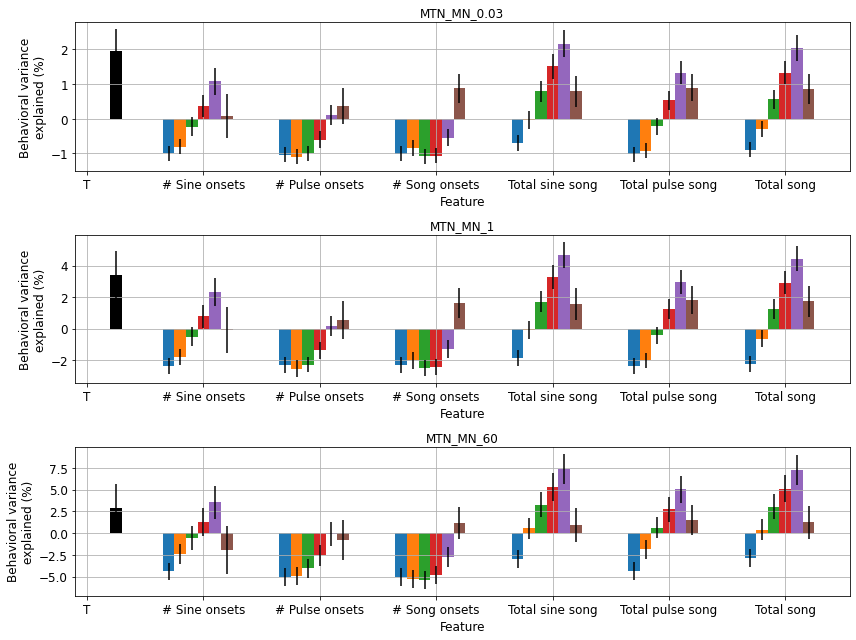

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9), tight_layout=True)
w_bar = 0.1

for ax, targ in zip(axs, TARGS):
    r2_test_mn = data['r2_test'][targ].mean(0)
    r2_test_sem = data['r2_test'][targ].std(0)/np.sqrt(len(data['heurs']))
    
    r2_test_mn_dict = {heur: r2_test_mn_ for heur, r2_test_mn_ in zip(data['heurs'], r2_test_mn)}
    r2_test_sem_dict = {heur: r2_test_sem_ for heur, r2_test_sem_ in zip(data['heurs'], r2_test_sem)}
    
    x_off = -.75
    x = np.array([x_off])
    y = np.array([r2_test_mn_dict['T']])
    y_err = np.array([r2_test_sem_dict['T']])
    
    ax.bar(x, 100*y, yerr=100*y_err, width=w_bar, color='k')
    
    for cwdw, wdw in enumerate(WDWS_HEUR):
        x_off = w_bar*cwdw - 0.3
        x = np.arange(len(SONG_HEURS)) + x_off
        y = np.array([r2_test_mn_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        y_err = np.array([r2_test_sem_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        ax.bar(x, 100*y, yerr=100*y_err, width=w_bar)
        
    ax.set_xticks(-1+np.arange(len(SONG_HEURS)+1))
    ax.set_xticklabels(['T'] + [LABELS[song_heur] for song_heur in SONG_HEURS])
    ax.set_xlabel('Feature')
    
    set_plot(ax, y_label='Behavioral variance\nexplained (%)', title=targ, font_size=12)
    ax.grid()
    
fig.savefig('supp/fig2s1b.svg')

In [19]:
SONG_HEURS = ['N_S_ONSETS', 'N_P_ONSETS', 'N_B_ONSETS', 'S_TOTAL', 'P_TOTAL', 'B_TOTAL']
LABELS = {
    'N_S_ONSETS': '# Sine onsets',
    'N_P_ONSETS': '# Pulse onsets',
    'N_B_ONSETS': '# Song onsets',
    'S_TOTAL': 'Total sine song',
    'P_TOTAL': 'Total pulse song',
    'B_TOTAL': 'Total song',
}
WDWS_HEUR = [1, 10, 30, 60, 120, 1800]
# WDWS_HEUR = [1, 10, 30, 60, 120]

# STRAINS_WONKY = ['CM07', 'CSTul', 'N30', 'ZW109']
STRAINS_WONKY = ['CM07', 'CSTul']
# STRAINS_WONKY = ['N30', 'ZW109']
STRAIN_KEY_WONKY = '_'.join(STRAINS_WONKY).lower()
FSAVE = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY_WONKY}_{TARG_BHV.lower()}.npy'

data = np.load(FSAVE, allow_pickle=True)[0]

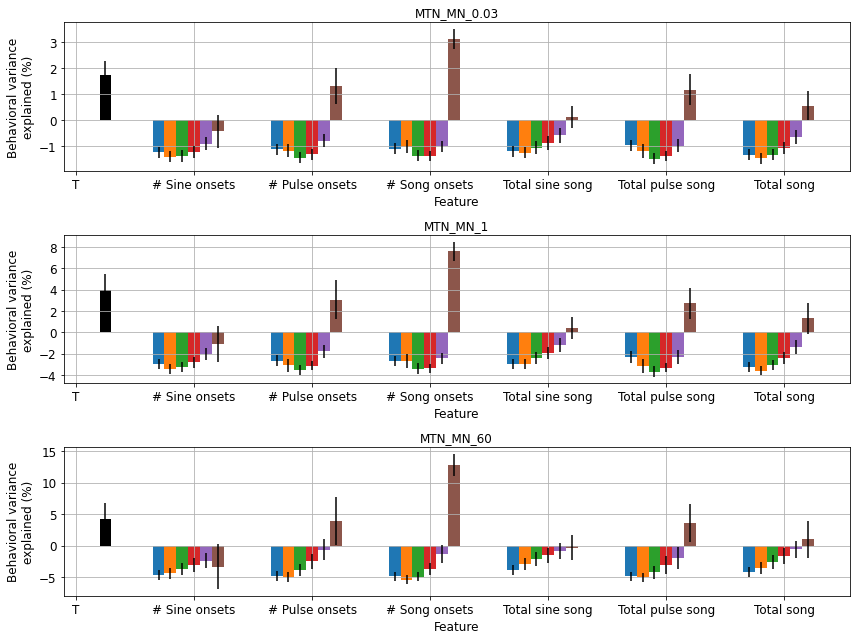

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9), tight_layout=True)
w_bar = 0.1

for ax, targ in zip(axs, TARGS):
    r2_test_mn = data['r2_test'][targ].mean(0)
    r2_test_sem = data['r2_test'][targ].std(0)/np.sqrt(len(data['heurs']))
    
    r2_test_mn_dict = {heur: r2_test_mn_ for heur, r2_test_mn_ in zip(data['heurs'], r2_test_mn)}
    r2_test_sem_dict = {heur: r2_test_sem_ for heur, r2_test_sem_ in zip(data['heurs'], r2_test_sem)}
    
    x_off = -.75
    x = np.array([x_off])
    y = np.array([r2_test_mn_dict['T']])
    y_err = np.array([r2_test_sem_dict['T']])
    
    ax.bar(x, 100*y, yerr=100*y_err, width=w_bar, color='k')
    
    for cwdw, wdw in enumerate(WDWS_HEUR):
        x_off = w_bar*cwdw - 0.3
        x = np.arange(len(SONG_HEURS)) + x_off
        y = np.array([r2_test_mn_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        y_err = np.array([r2_test_sem_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        ax.bar(x, 100*y, yerr=100*y_err, width=w_bar)
        
    ax.set_xticks(-1+np.arange(len(SONG_HEURS)+1))
    ax.set_xticklabels(['T'] + [LABELS[song_heur] for song_heur in SONG_HEURS])
    ax.set_xlabel('Feature')
    
    set_plot(ax, y_label='Behavioral variance\nexplained (%)', title=targ, font_size=12)
    ax.grid()

In [11]:
SONG_HEURS = ['N_S_ONSETS', 'N_P_ONSETS', 'N_B_ONSETS', 'S_TOTAL', 'P_TOTAL', 'B_TOTAL']
LABELS = {
    'N_S_ONSETS': '# Sine onsets',
    'N_P_ONSETS': '# Pulse onsets',
    'N_B_ONSETS': '# Song onsets',
    'S_TOTAL': 'Total sine song',
    'P_TOTAL': 'Total pulse song',
    'B_TOTAL': 'Total song',
}
WDWS_HEUR = [1, 10, 30, 60, 120, 1800]
# WDWS_HEUR = [1, 10, 30, 60, 120]

STRAINS_ALL = ['NM91', 'ZH23', 'CM07', 'CSTul', 'N30', 'ZW109']
STRAIN_KEY_ALL = '_'.join(STRAINS_ALL).lower()
FSAVE = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY_ALL}_{TARG_BHV.lower()}.npy'

data = np.load(FSAVE, allow_pickle=True)[0]

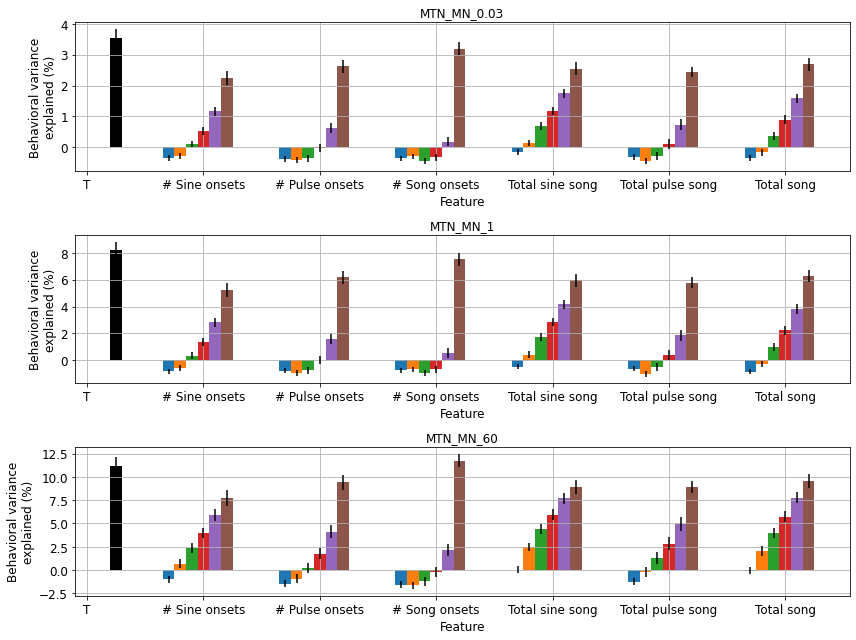

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9), tight_layout=True)
w_bar = 0.1

for ax, targ in zip(axs, TARGS):
    r2_test_mn = data['r2_test'][targ].mean(0)
    r2_test_sem = data['r2_test'][targ].std(0)/np.sqrt(len(data['heurs']))
    
    r2_test_mn_dict = {heur: r2_test_mn_ for heur, r2_test_mn_ in zip(data['heurs'], r2_test_mn)}
    r2_test_sem_dict = {heur: r2_test_sem_ for heur, r2_test_sem_ in zip(data['heurs'], r2_test_sem)}
    
    x_off = -.75
    x = np.array([x_off])
    y = np.array([r2_test_mn_dict['T']])
    y_err = np.array([r2_test_sem_dict['T']])
    
    ax.bar(x, 100*y, yerr=100*y_err, width=w_bar, color='k')
    
    for cwdw, wdw in enumerate(WDWS_HEUR):
        x_off = w_bar*cwdw - 0.3
        x = np.arange(len(SONG_HEURS)) + x_off
        y = np.array([r2_test_mn_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        y_err = np.array([r2_test_sem_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        ax.bar(x, 100*y, yerr=100*y_err, width=w_bar)
        
    ax.set_xticks(-1+np.arange(len(SONG_HEURS)+1))
    ax.set_xticklabels(['T'] + [LABELS[song_heur] for song_heur in SONG_HEURS])
    ax.set_xlabel('Feature')
    
    set_plot(ax, y_label='Behavioral variance\nexplained (%)', title=targ, font_size=12)
    ax.grid()

In [15]:
SONG_HEURS = ['N_S_ONSETS', 'N_P_ONSETS', 'N_B_ONSETS', 'S_TOTAL', 'P_TOTAL', 'B_TOTAL']
LABELS = {
    'N_S_ONSETS': '# Sine onsets',
    'N_P_ONSETS': '# Pulse onsets',
    'N_B_ONSETS': '# Song onsets',
    'S_TOTAL': 'Total sine song',
    'P_TOTAL': 'Total pulse song',
    'B_TOTAL': 'Total song',
}
WDWS_HEUR = [1, 10, 30, 60, 120, 1800]
# WDWS_HEUR = [1, 10, 30, 60, 120]

STRAINS_WTG = ['WTG']
STRAIN_KEY_WTG = '_'.join(STRAINS_WTG).lower()
FSAVE = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY_WTG}_{TARG_BHV.lower()}.npy'

data = np.load(FSAVE, allow_pickle=True)[0]

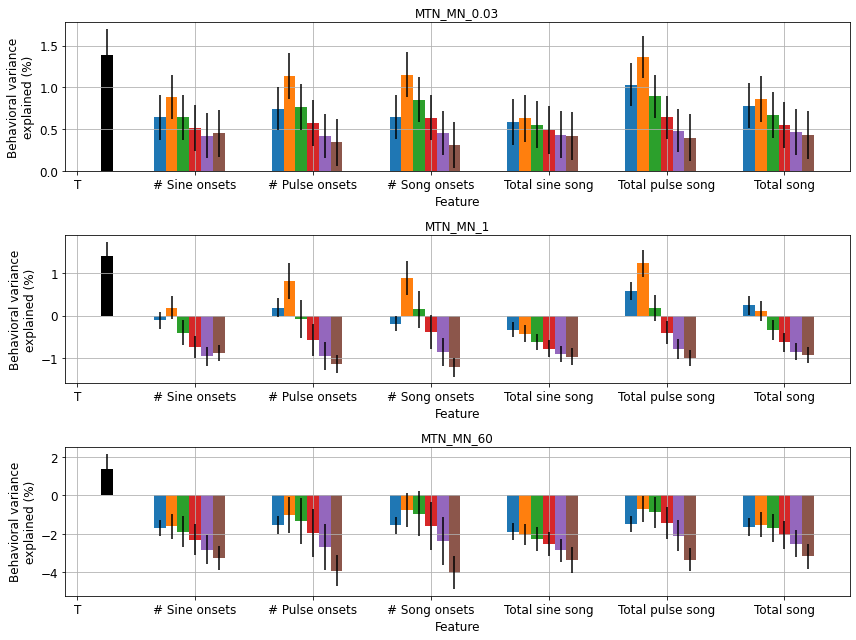

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9), tight_layout=True)
w_bar = 0.1

for ax, targ in zip(axs, TARGS):
    r2_test_mn = data['r2_test'][targ].mean(0)
    r2_test_sem = data['r2_test'][targ].std(0)/np.sqrt(len(data['heurs']))
    
    r2_test_mn_dict = {heur: r2_test_mn_ for heur, r2_test_mn_ in zip(data['heurs'], r2_test_mn)}
    r2_test_sem_dict = {heur: r2_test_sem_ for heur, r2_test_sem_ in zip(data['heurs'], r2_test_sem)}
    
    x_off = -.75
    x = np.array([x_off])
    y = np.array([r2_test_mn_dict['T']])
    y_err = np.array([r2_test_sem_dict['T']])
    
    ax.bar(x, 100*y, yerr=100*y_err, width=w_bar, color='k')
    
    for cwdw, wdw in enumerate(WDWS_HEUR):
        x_off = w_bar*cwdw - 0.3
        x = np.arange(len(SONG_HEURS)) + x_off
        y = np.array([r2_test_mn_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        y_err = np.array([r2_test_sem_dict[f'{heur}_{wdw}'] for heur in SONG_HEURS])
        ax.bar(x, 100*y, yerr=100*y_err, width=w_bar)
        
    ax.set_xticks(-1+np.arange(len(SONG_HEURS)+1))
    ax.set_xticklabels(['T'] + [LABELS[song_heur] for song_heur in SONG_HEURS])
    ax.set_xlabel('Feature')
    
    set_plot(ax, y_label='Behavioral variance\nexplained (%)', title=targ, font_size=12)
    ax.grid()

# Expanded comparison of single vs population fit with different models

In [15]:
TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]

NRL_MDLS = [
    'lin',  # linear neural model
    'lin2e',  # linear neural model (two-exp fit)
    'linr',  # linear neural model (fit w ridge regr)
    'ln',  # linear-nonlinear model
    'ln2e',  # linear-nonlinear model (two-exp fit)
    'lnr',  # linear-nonlinear model (fit w ridge regr)
    'ma',  # mult-adapt neural model
    'masoff',  # mult-adapt neural model with sine offset responses
]

In [16]:
# heuristic predictors
time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]

# linear fits
lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]

# single-neuorn fits
single_rslts = [
    np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]
    for nrl_mdl in NRL_MDLS
]

# ppln fits
ppln_rslts = [
    np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
    for nrl_mdl in NRL_MDLS
]

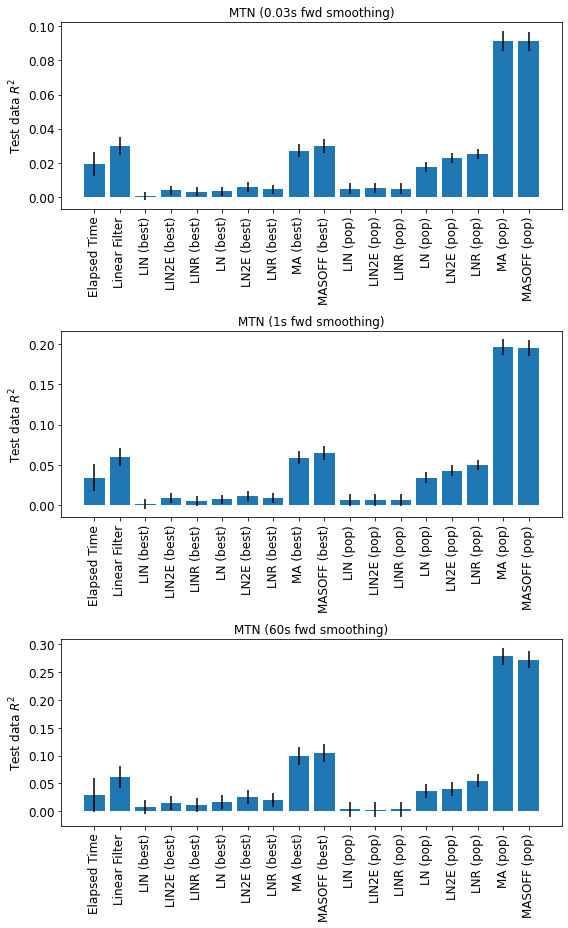

In [17]:
fig, axs = plt.subplots(len(TWDWS), 1, figsize=(8, 13), tight_layout=True)
                
for ax, twdw in zip(axs, TWDWS):
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    # heuristics
    labels.append('Elapsed Time')
    r2_mns.append(time_rslt['r2_test'][targ].mean())
    r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))
    
    # linear fits
    labels.append('Linear Filter')
    r2_mns.append(lin_rslt['r2_test'][targ].mean())
    r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))
    
    # single neuron results
    for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
        r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
        labels.append(f'{nrl_mdl.upper()} (best)')
        r2_mns.append(r2_maxs.mean())
        r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))
        
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{nrl_mdl.upper()} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
    ax.bar(np.arange(len(r2_mns)), r2_mns, yerr=r2_sems)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    set_plot(ax, y_label=r'Test data $R^2$', title=f'{TARG_BHV} ({twdw}s fwd smoothing)', font_size=12)

# Predictability of female motion from top PCs of neural activity

## Direct measurements of surrogate neural activity

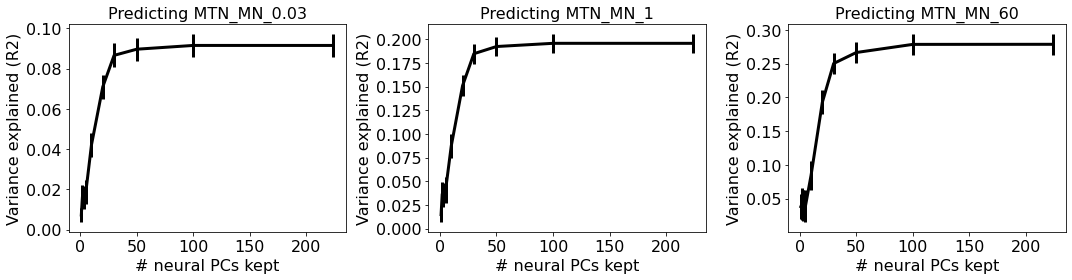

In [34]:
NPCS = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 224])

r2_test_mns = {targ: [] for targ in TARGS}
r2_test_sems = {targ: [] for targ in TARGS}

for npc in NPCS:
    data = np.load(f'data/simple/mlv/neur_basic/baker_ma_pca/baker_ma_nm91_zh23_mtn_ridge_alpha_10_{npc}_pc.npy', allow_pickle=True)[0]
    for targ in TARGS:
        r2_test = data['r2_test'][targ]
        r2_test_mns[targ].append(r2_test.mean())
        
        r2_test_sd = r2_test.std()
        r2_test_sems[targ].append(r2_test_sd/np.sqrt(len(r2_test)))
        
fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
for targ, ax in zip(TARGS, axs):
    ax.errorbar(NPCS, r2_test_mns[targ], yerr=r2_test_sems[targ], lw=3, c='k')
    ax.set_title(f'Predicting {targ}')
    ax.set_xlabel('# neural PCs kept')
    ax.set_ylabel('Variance explained (R2)')
    set_plot(ax, font_size=16)

## Z-scored neural activity

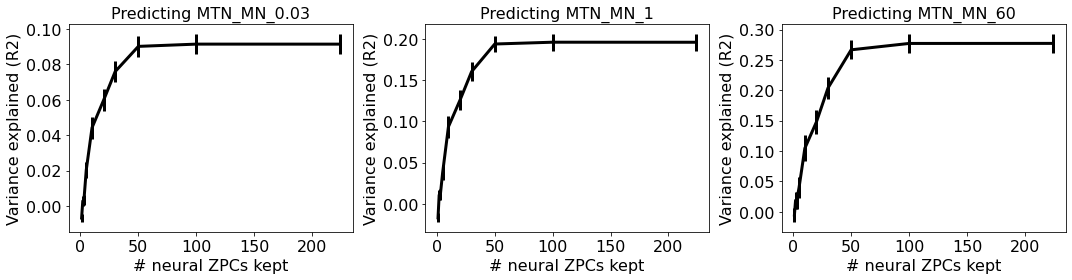

In [38]:
NPCS = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 224])

r2_test_mns = {targ: [] for targ in TARGS}
r2_test_sems = {targ: [] for targ in TARGS}

for npc in NPCS:
    data = np.load(f'data/simple/mlv/neur_basic/baker_ma_zpca/baker_ma_nm91_zh23_mtn_ridge_alpha_10_{npc}_zpc.npy', allow_pickle=True)[0]
    for targ in TARGS:
        r2_test = data['r2_test'][targ]
        r2_test_mns[targ].append(r2_test.mean())
        
        r2_test_sd = r2_test.std()
        r2_test_sems[targ].append(r2_test_sd/np.sqrt(len(r2_test)))
        
fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
for targ, ax in zip(TARGS, axs):
    ax.errorbar(NPCS, r2_test_mns[targ], yerr=r2_test_sems[targ], lw=3, c='k')
    ax.set_title(f'Predicting {targ}')
    ax.set_xlabel('# neural ZPCs kept')
    ax.set_ylabel('Variance explained (R2)')
    set_plot(ax, font_size=16)

# Predictability of female motion from top PCs of systematically built MA ppln activity

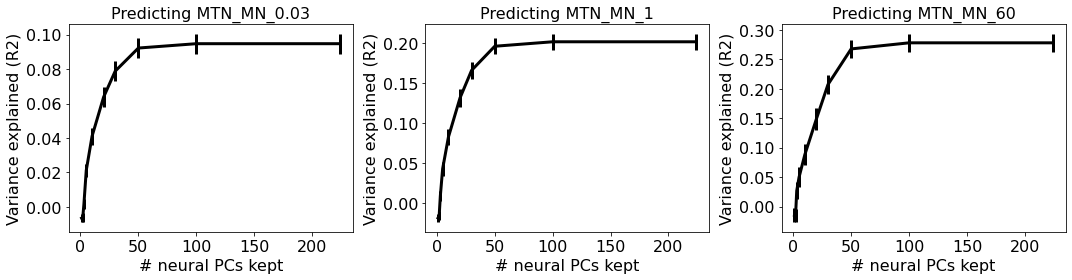

In [45]:
NPCS = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 224])

r2_test_mns = {targ: [] for targ in TARGS}
r2_test_sems = {targ: [] for targ in TARGS}

for npc in NPCS:
    data = np.load(f'data/simple/mlv/ma_red_greedy/nrl_pca/ma_red_greedy_nm91_zh23_mtn_ridge_alpha_10_{npc}_pc.npy', allow_pickle=True)[0]
    for targ in TARGS:
        r2_test = data['r2_test'][targ]
        r2_test_mns[targ].append(r2_test.mean())
        
        r2_test_sd = r2_test.std()
        r2_test_sems[targ].append(r2_test_sd/np.sqrt(len(r2_test)))
        
fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
for targ, ax in zip(TARGS, axs):
    ax.errorbar(NPCS, r2_test_mns[targ], yerr=r2_test_sems[targ], lw=3, c='k')
    ax.set_title(f'Predicting {targ}')
    ax.set_xlabel('# neural PCs kept')
    ax.set_ylabel('Variance explained (R2)')
    set_plot(ax, font_size=16)

# OLD: Analysis of perturbed neural population predictions of female locomotion

In [18]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full M-A population'),
    ('ma_non_select', 'ma_alt', 'No selectivity'),
    ('ma_pure_select', 'ma_alt', 'Pure selectivity'),
    ('ma_sine_select', 'ma_alt', 'Sine sel. only'),
    ('ma_pulse_select', 'ma_alt', 'Pulse sel. only'),
    ('ma_dep_only', 'ma_alt', 'Depolarizing only'),
    ('ma_hyp_only', 'ma_alt', 'Hyperpolarizing only'),
    ('ma_nonadapt', 'ma_alt', 'Nonadapting'),
    ('ma_tau_const', 'ma_alt', r'All med. $\tau_r, \tau_a$ (2s, 11s)'),
    ('ma_med_tau_a', 'ma_alt', r'All median $\tau_a$ (11s)'),
    ('ma_med_tau_r', 'ma_alt', r'All median $\tau_r$ (2s)'),
    ('ma_sia', 'ma_alt', 'Stim-invariant adapt'),
    ('ma_max_tau_a_1', 'ma_alt', r'All $\tau_a$<1s'),
    ('ma_max_tau_a_2', 'ma_alt', r'All $\tau_a$<2s'),
    ('ma_max_tau_a_5', 'ma_alt', r'All $\tau_a$<5s'),
    ('ma_max_tau_a_10', 'ma_alt', r'All $\tau_a$<10s'),
    ('ma_tau_a_0.5', 'ma_alt', r'All $\tau_a =$0.5s'),
    ('ma_tau_a_1', 'ma_alt', r'All $\tau_a =$1s'),
    ('ma_tau_a_2', 'ma_alt', r'All $\tau_a =$2s'),
    ('ma_tau_a_5', 'ma_alt', r'All $\tau_a =$5s'),
    ('ma_tau_r_5', 'ma_alt', r'All $\tau_r =$5s'),
    ('ma_tau_r_10', 'ma_alt', r'All $\tau_r =$10s'),
    ('ma_tau_r_15', 'ma_alt', r'All $\tau_r =$15s'),
    ('ma_tau_r_30', 'ma_alt', r'All $\tau_r =$30s'),
    ('ma_tau_r_60', 'ma_alt', r'All $\tau_r =$60s'),
    ('ma_tau_r_120', 'ma_alt', r'All $\tau_r =$120s'),
    ('ma_nonadapt_tau_r_60', 'ma_alt', r'All $\tau_r =$60s, nonadapting'),
    ('ma_max_tau_a_1_tau_r_120', 'ma_alt', r'All $\tau_a$<1, all $\tau_r =$120'),
    ('ma_max_tau_a_1_tau_r_120_pulse', 'ma_alt', r'All $\tau_a$<1, all $\tau_r =$120, pulse only'),
    ('ma_max_tau_a_1_tau_r_120_sine', 'ma_alt', r'All $\tau_a$<1, all $\tau_r =$120, sine only'),
#     ('ma_fast_adapt_slow_decay_pulse_only', 'ma_thry', r'Max $\tau_a$ 1, fixed $\tau_r$ 120, pulse only'),
#     ('ma_fast_adapt_slow_decay_var_select', 'ma_thry', r'Max $\tau_a$ 1, fixed $\tau_r$ 120, var select'),
#     ('ma_fast_adapt_slow_decay', 'ma_thry', r'Max $\tau_a$ 1, fixed $\tau_r$ 120, pure select'),
#     ('ma_fast_adapt_0.3_1_slow_decay', 'ma_thry', r'$\tau_a$ 0.3 or 1, fixed $\tau_r$ 120, pure select'),
#     ('ma_dense_fast_adapt_slow_decay', 'ma_thry', r'Max $\tau_a$ 1 (denser), fixed $\tau_r$ 120, pure select'),
]

rslts = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder != 'ma_thry':
        fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_ffv_mn_60_ridge_alpha_10.npy', allow_pickle=True)[0]
    elif folder == 'ma_thry':
        fit_data = np.load(f'data/simple/mlv/{folder}/{kbhv}_nm91_zh23_ffv_mn_60_ridge_alpha_10.npy', allow_pickle=True)[0]
        
    
    nsplit = len(fit_data['r2_test']['FFV_MN_60'])
    
    r2 = fit_data['r2_test']['FFV_MN_60'].mean()
    err = fit_data['r2_test']['FFV_MN_60'].std()/np.sqrt(nsplit)
#     r2 = fit_data['r2_test']['FFV'].mean()
#     err = fit_data['r2_test']['FFV'].std()/np.sqrt(nsplit)
    
    rslts.append((key, r2, err))

FileNotFoundError: [Errno 2] No such file or directory: 'data/simple/mlv/ma_alt/baker_ma_non_select_nm91_zh23_ffv_mn_60_ridge_alpha_10.npy'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, .5*len(rslts)), tight_layout=True, sharey=True)
for crslt, (key, r2, err) in enumerate(rslts):
    ax.barh([-crslt], [r2*100], xerr=[err*100])

ax.axvline(100*rslts[0][1], ls='--', lw=.75)
ax.set_yticks(-np.arange(len(rslts)))
ax.set_yticklabels([rslt[0] for rslt in rslts])

ax.axvline(0, color='gray', lw=.5)
set_plot(ax, x_label='Behav. var. explained (%)', font_size=14)

### Paper figure

In [ ]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full MA population'),
    (None, None, None),
    ('ma_non_select', 'ma_alt', 'No selectivity'),
    ('ma_pure_select', 'ma_alt', 'Pure selectivity'),
    (None, None, None),
    ('ma_sine_select', 'ma_alt', 'Sine sel. only'),
    ('ma_pulse_select', 'ma_alt', 'Pulse sel. only'),
    (None, None, None),
    ('ma_dep_only', 'ma_alt', 'Depolarizing only'),
    ('ma_hyp_only', 'ma_alt', 'Hyperpolarizing only'),
    (None, None, None),
    ('ma_nonadapt', 'ma_alt', 'Nonadapting'),
    ('ma_sia', 'ma_alt', 'Stim-invariant adapt'),
    (None, None, None),
#     ('ma_tau_const', 'ma_alt', r'All med. $\tau_r, \tau_a$ (2s, 11s)'),
    ('ma_tau_a_0.5', 'ma_alt', r'$\tau_a =$.5s'),
    ('ma_tau_a_1', 'ma_alt', r'$\tau_a =$1s'),
    ('ma_tau_a_2', 'ma_alt', r'$\tau_a =$2s'),
    ('ma_tau_a_5', 'ma_alt', r'$\tau_a =$5s'),
    ('ma_med_tau_a', 'ma_alt', r'$\tau_a=$11s'),
    (None, None, None),
    ('ma_med_tau_r', 'ma_alt', r'$\tau_r=$2s'),
    ('ma_tau_r_5', 'ma_alt', r'$\tau_r =$5s'),
    ('ma_tau_r_10', 'ma_alt', r'$\tau_r =$10s'),
    ('ma_tau_r_15', 'ma_alt', r'$\tau_r =$15s'),
    ('ma_tau_r_30', 'ma_alt', r'$\tau_r =$30s'),
    ('ma_tau_r_60', 'ma_alt', r'$\tau_r =$60s'),
    ('ma_tau_r_120', 'ma_alt', r'$\tau_r =$120s'),
    (None, None, None),
    ('ma_max_tau_a_1', 'ma_alt', r'$\tau_a$ < 1s'),
    ('ma_max_tau_a_2', 'ma_alt', r'$\tau_a$ < 2s'),
    ('ma_max_tau_a_5', 'ma_alt', r'$\tau_a$ < 5s'),
    ('ma_max_tau_a_10', 'ma_alt', r'$\tau_a$ < 10s'),
    (None, None, None),
    ('ma_max_tau_a_1_tau_r_120', 'ma_alt', r'$\tau_a < 1s$, $\tau_r =$120s'),
    (None, None, None),
    ('ma_max_tau_a_1_tau_r_120_pulse', 'ma_alt', r'P only, $\tau_a$<1s, $\tau_r =$120s'),
    ('ma_max_tau_a_1_tau_r_120_sine', 'ma_alt', r'S only, $\tau_a$<1s, $\tau_r =$120s'),
#     ('ma_fast_adapt_slow_decay_pulse_only', 'ma_thry', r'Max $\tau_a$ 1, fixed $\tau_r$ 120, pulse only'),
#     ('ma_fast_adapt_slow_decay_var_select', 'ma_thry', r'Max $\tau_a$ 1, fixed $\tau_r$ 120, var select'),
#     ('ma_fast_adapt_slow_decay', 'ma_thry', r'Max $\tau_a$ 1, fixed $\tau_r$ 120, pure select'),
#     ('ma_fast_adapt_0.3_1_slow_decay', 'ma_thry', r'$\tau_a$ 0.3 or 1, fixed $\tau_r$ 120, pure select'),
#     ('ma_dense_fast_adapt_slow_decay', 'ma_thry', r'Max $\tau_a$ 1 (denser), fixed $\tau_r$ 120, pure select'),
]

rslts = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder is not None:
        fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_ffv_mn_60_ridge_alpha_10.npy', allow_pickle=True)[0]
        nsplit = len(fit_data['r2_test']['FFV_MN_60'])

        r2 = fit_data['r2_test']['FFV_MN_60'].mean()
        err = fit_data['r2_test']['FFV_MN_60'].std()/np.sqrt(nsplit)
#         r2 = fit_data['r2_test']['FFV'].mean()
#         err = fit_data['r2_test']['FFV'].std()/np.sqrt(nsplit)
    else:
        r2 = np.nan
        err = np.nan
    
    rslts.append((key, r2, err))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7), tight_layout=True, sharey=True)
for crslt, (key, r2, err) in enumerate(rslts):
    ax.bar([crslt], [r2*100], yerr=[err*100])

ax.axhline(100*rslts[0][1], ls='--', lw=.75)
ax.set_xticks(np.arange(len(rslts)))
ax.set_xticklabels([rslt[0] for rslt in rslts], rotation=90)

ax.axhline(0, color='gray', lw=.5)
set_plot(ax, y_label='FFV variance explained (%)', title='FFV from perturbed neural populations', font_size=16)

fig.savefig('ms/fig2e.svg')

# Analysis of reduced population neural recordings

In [ ]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full M-A population'),
    ('ma_fast_adapt_slow_decay_pulse_only', 'ma_thry', r'P only, $\tau_a$ < 1s, $\tau_r$ = 120s'),
    ('ma_fast_adapt_slow_decay_var_select', 'ma_thry', r'Mixed sel, $\tau_a$ < 1s, $\tau_r$ = 120s'),
    ('ma_fast_adapt_slow_decay', 'ma_thry', r'Pure sel, $\tau_a$ < 1s, $\tau_r$ = 120s'),
    ('ma_fast_adapt_0.3_1_slow_decay', 'ma_thry', r'Pure sel, $\tau_a$ = 0.3 or 1, $\tau_r$ = 120s'),
    ('ma_dense_fast_adapt_slow_decay', 'ma_thry', r'Pure sel, $\tau_a$ 1 (denser), $\tau_r$ 120'),
]

rslts = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder != 'ma_thry':
        fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_ffv_mn_60_ridge_alpha_10.npy', allow_pickle=True)[0]
    elif folder == 'ma_thry':
        fit_data = np.load(f'data/simple/mlv/{folder}/{kbhv}_nm91_zh23_ffv_mn_60_ridge_alpha_10.npy', allow_pickle=True)[0]
        
    
    nsplit = len(fit_data['r2_test']['FFV_MN_60'])
    
    r2 = fit_data['r2_test']['FFV_MN_60'].mean()
    err = fit_data['r2_test']['FFV_MN_60'].std()/np.sqrt(nsplit)
#     r2 = fit_data['r2_test']['FFV'].mean()
#     err = fit_data['r2_test']['FFV'].std()/np.sqrt(nsplit)
    
    rslts.append((key, r2, err))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, .5*len(rslts)), tight_layout=True, sharey=True)
for crslt, (key, r2, err) in enumerate(rslts):
    ax.barh([-crslt], [r2*100], xerr=[err*100])

ax.axvline(100*rslts[0][1], ls='--', lw=.75)
ax.set_yticks(-np.arange(len(rslts)))
ax.set_yticklabels([rslt[0] for rslt in rslts])

ax.axvline(0, color='gray', lw=.5)
set_plot(ax, x_label='Behav. var. explained (%)', font_size=14)

## Paper figure

In [ ]:
KBHVS_FOLDERS_KEYS = [
    ('ma', 'neur_basic', 'Full M-A population'),
    ('ma_fast_adapt_slow_decay_pulse_only', 'ma_thry', r'P only, $\tau_a$ < 1s, $\tau_r$ = 120s'),
    ('ma_fast_adapt_slow_decay_var_select', 'ma_thry', r'Mixed, $\tau_a$ < 1s, $\tau_r$ = 120s'),
    ('ma_fast_adapt_slow_decay', 'ma_thry', r'Pure, $\tau_a$ < 1s, $\tau_r$ = 120s'),
    ('ma_fast_adapt_0.3_1_slow_decay', 'ma_thry', r'Pure, $\tau_a$ = 0.3, 1s, $\tau_r$ = 120s'),
#     ('ma_dense_fast_adapt_slow_decay', 'ma_thry', r'Max $\tau_a$ 1 (denser), fixed $\tau_r$ 120, pure select'),
]

rslts = []

for kbhv, folder, key in KBHVS_FOLDERS_KEYS:
    if folder != 'ma_thry':
        fit_data = np.load(f'data/simple/mlv/{folder}/baker_{kbhv}_nm91_zh23_ffv_mn_60_ridge_alpha_10.npy', allow_pickle=True)[0]
    elif folder == 'ma_thry':
        fit_data = np.load(f'data/simple/mlv/{folder}/{kbhv}_nm91_zh23_ffv_mn_60_ridge_alpha_10.npy', allow_pickle=True)[0]
        
    
    nsplit = len(fit_data['r2_test']['FFV_MN_60'])
    
    r2 = fit_data['r2_test']['FFV_MN_60'].mean()
    err = fit_data['r2_test']['FFV_MN_60'].std()/np.sqrt(nsplit)
#     r2 = fit_data['r2_test']['FFV'].mean()
#     err = fit_data['r2_test']['FFV'].std()/np.sqrt(nsplit)
    
    rslts.append((key, r2, err))

fig, ax = plt.subplots(1, 1, figsize=(4, 6), tight_layout=True, sharey=True)
for crslt, (key, r2, err) in enumerate(rslts):
    ax.bar([crslt], [r2*100], yerr=[err*100])

ax.axhline(100*rslts[0][1], ls='--', lw=.75)
ax.set_xticks(np.arange(len(rslts)))
ax.set_xticklabels([rslt[0] for rslt in rslts], rotation=90)

ax.axhline(0, color='gray', lw=.5)
set_plot(ax, y_label='FFV var. explained (%)', title='FFV from reduced population', font_size=14)

fig.savefig('ms/fig2f.svg')

# Neural activity projected onto top PCs

In [ ]:
KBEHAVS = ['FFV', 'FLS']

rslts = {kbehav: [] for kbehav in KBEHAVS}

# load population ROI results
for npc in [3, 10, 224]:
    for kbehav in KBEHAVS:
        fit_data = np.load(f'data/simple/mlv/neur_basic/baker_ma_pca_npc_{npc}_{kbehav.lower()}_276_tr.npy', allow_pickle=True)[0]

        key = f'MA neurons\n{npc} PCs'

        r2 = fit_data['r2_test'].mean()
        nsplit = len(fit_data['r2_test'])
        err = fit_data['r2_test'].std()/np.sqrt(nsplit)

        rslts[kbehav].append((key, r2, err))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, len(rslts[KBEHAVS[0]])), tight_layout=True, sharex=True, sharey=True)
for kbehav, ax in zip(KBEHAVS, axs):
    for crslt, (key, r2, err) in enumerate(rslts[kbehav]):
        ax.barh([-crslt], [r2*100], xerr=[err*100])
        
    if ax == axs[0]:
        ax.set_yticks(-np.arange(len(rslts[kbehav])))
        ax.set_yticklabels([rslt[0] for rslt in rslts[kbehav]])
        
    ax.axvline(0, color='gray', lw=.5)
    set_plot(ax, x_label='Behavioral variance explained (%)', title=kbehav, font_size=14)